In [1]:
from utils import image_conversion
import pydicom
import monai
from monai.networks.nets import UNet, Discriminator
from monai.transforms import (
    Compose,
    LoadNifti,
    LoadNiftid,
    NormalizeIntensity,
    NormalizeIntensityd,
    AddChannel,
    AddChanneld,
    ToTensor,
    ToTensord,
    RandCropByPosNegLabeld
)
from monai.inferers import sliding_window_inference

import torch
import torch.nn.functional as F
import torchvision

import pytorch_lightning as pl
from sklearn.model_selection import train_test_split

import numpy as np
from argparse import Namespace

import SimpleITK as sitk

In [ ]:
class MaskGAN(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = Namespace(**hparams)

        self.generator = UNet(
            dimensions=3,
            in_channels=1,
            out_channels=2,
            channels=(64, 128, 258, 512, 1024),
            strides=(2, 2, 2, 2),
            norm=monai.networks.layers.Norm.BATCH,
            dropout=0,
        )

        self.discriminator = Discriminator(
            in_shape=self.hparams.patch_size,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            norm=monai.networks.layers.Norm.BATCH,
        )

        self.generated_masks = None
        self.sample_masks = []

    # Data setup
    def setup(self, stage):
        data_dir = "data/"

        # Train imgs/masks
        train_imgs = []
        with open(data_dir + "train_imgs.txt", "r") as f:
            train_imgs = [image.rstrip() for image in f.readlines()]

        train_masks = []
        with open(data_dir + "train_masks.txt", "r") as f:
            train_masks = [mask.rstrip() for mask in f.readlines()]

        train_dicts = [
            {"image": image, "mask": mask}
            for (image, mask) in zip(train_imgs, train_masks)
        ]

        train_dicts, val_dicts = train_test_split(train_dicts, test_size=0.2)

        # Basic transforms
        data_keys = ["image", "mask"]
        data_transforms = Compose(
            [
                AddChanneld(keys=data_keys),
                NormalizeIntensityd(keys="image"),
                RandCropByPosNegLabeld(
                    keys=data_keys,
                    label_key="mask",
                    spatial_size=self.hparams.patch_size,
                    num_samples=4,
                    image_key="image",
                ),
            ]
        )

        self.train_dataset = monai.data.CacheDataset(
            data=train_dicts,
            transform=Compose([data_transforms, ToTensord(keys=data_keys)]),
            cache_rate=1.0,
        )

        self.val_dataset = monai.data.CacheDataset(
            data=val_dicts,
            transform=Compose([data_transforms, ToTensord(keys=data_keys)]),
            cache_rate=1.0,
        )

    def train_dataloader(self):
        return monai.data.DataLoader(
            self.train_dataset,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=hparams.num_workers,
        )

    def val_dataloader(self):
        return monai.data.DataLoader(
            self.val_dataset,
            batch_size=self.hparams.batch_size,
            num_workers=hparams.num_workers,
        )

    # Training setup
    def forward(self, image):
        return self.generator(image)

    def generator_loss(self, y_hat, y):
        dice_loss = monai.losses.DiceLoss(to_onehot_y=True, softmax=True)
        return dice_loss(y_hat, y)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
        inputs, labels = batch["image"], batch["mask"]
        batch_size = inputs.size(0)
        # Generator training
        if optimizer_idx == 0:
            self.generated_masks = self(inputs)

            # Loss from difference between real and generated masks
            g_loss = self.generator_loss(self.generated_masks, labels)

            # Loss from discriminator
            # The generator wants the discriminator to be wrong,
            # so the wrong labels are used
            fake_labels = torch.ones(batch_size, 1).cuda(inputs.device.index)
            d_loss = self.adversarial_loss(
                self.discriminator(
                    self.generated_masks.argmax(1)
                    .type(torch.FloatTensor)
                    .cuda(inputs.device.index)
                ),
                fake_labels,
            )

            avg_loss = (g_loss + d_loss) / 2

            self.logger.log_metrics({"g_train/g_loss": g_loss}, self.global_step)
            self.logger.log_metrics({"g_train/d_loss": d_loss}, self.global_step)
            self.logger.log_metrics({"g_train/tot_loss": avg_loss}, self.global_step)
            return {"loss": avg_loss}

        # Discriminator trainig
        else:
            # Learning real masks
            real_labels = torch.ones(batch_size, 1).cuda(inputs.device.index)
            real_loss = self.adversarial_loss(
                self.discriminator(
                    labels.squeeze(1).type(torch.FloatTensor).cuda(inputs.device.index)
                ),
                real_labels,
            )

            # Learning "fake" masks
            fake_labels = torch.zeros(batch_size, 1).cuda(inputs.device.index)
            fake_loss = self.adversarial_loss(
                self.discriminator(
                    self.generated_masks.argmax(1)
                    .detach()
                    .type(torch.FloatTensor)
                    .cuda(inputs.device.index)
                ),
                fake_labels,
            )

            avg_loss = (real_loss + fake_loss) / 2

            self.logger.log_metrics({"d_train/real_loss": real_loss}, self.global_step)
            self.logger.log_metrics({"d_train/fake_loss": fake_loss}, self.global_step)
            self.logger.log_metrics({"d_train/tot_loss": avg_loss}, self.global_step)

            return {"loss": avg_loss}

    def configure_optimizers(self):
        lr = self.hparams.lr
        g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr)
        d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [g_optimizer, d_optimizer], []

    def validation_step(self, batch, batch_idx):
        inputs, labels = (
            batch["image"],
            batch["mask"],
        )
        outputs = self(inputs)

        # Sample masks
        if self.current_epoch != 0:
            image = outputs[0].argmax(0)[:, :, 8].unsqueeze(0).detach()
            self.sample_masks.append(image)

        loss = self.generator_loss(outputs, labels)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        self.logger.log_metrics({"val/loss": avg_loss}, self.current_epoch)

        if self.current_epoch != 0:
            grid = torchvision.utils.make_grid(self.sample_masks)
            self.logger.experiment.add_image("sample_masks", grid, self.current_epoch)
            self.sample_masks = []

        return {"val_loss": avg_loss}

In [2]:
class UNet_DF(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        
        self.unet = UNet(
            dimensions=3,
            in_channels=1,
            out_channels=2,
            channels=(64, 128, 258, 512, 1024),
            strides=(2, 2, 2, 2),
            norm=monai.networks.layers.Norm.BATCH,
            dropout=0,
        )
        self.sample_masks = []
    
    # Data setup
    def setup(self, stage):
        data_df = pd.read_csv('/data/shared/prostate/yale_prostate/input_lists/MR_yale.csv')
        
        train_imgs = data_df['IMAGE'][0:295].tolist()
        train_masks = data_df['SEGM'][0:295].tolist()
        
        train_dicts = [{'image': image, 'mask': mask} for (image, mask) in zip(train_imgs, train_masks)]
        
        train_dicts, val_dicts = train_test_split(train_dicts, test_size=0.15)
        
        # Basic transforms
        data_keys = ["image", "mask"]
        data_transforms = Compose(
            [
                LoadNiftid(keys=data_keys),
                AddChanneld(keys=data_keys),
                NormalizeIntensityd(keys="image"),
                RandCropByPosNegLabeld(
                    keys=data_keys,
                    label_key="mask",
                    spatial_size=self.hparams.patch_size,
                    num_samples=4,
                    image_key="image",
                    pos=0.7,
                    neg=0.3
                ),
            ]
        )
        
        self.train_dataset = monai.data.CacheDataset(
            data=train_dicts,
            transform=Compose(
                [
                    data_transforms,
                    ToTensord(keys=data_keys)
                ]
            ),
            cache_rate=1.0
        )
        
        self.val_dataset = monai.data.CacheDataset(
            data=val_dicts,
            transform=Compose(
                [
                    data_transforms,
                    ToTensord(keys=data_keys)
                ]
            ),
            cache_rate=1.0
        )
        
    def train_dataloader(self):
        return monai.data.DataLoader(
            self.train_dataset, batch_size=self.hparams.batch_size, shuffle=True, num_workers=self.hparams.num_workers
        )

    def val_dataloader(self):
        return monai.data.DataLoader(
            self.val_dataset, batch_size=self.hparams.batch_size, num_workers=self.hparams.num_workers
        )
    
    # Training setup
    def forward(self, image):
        return self.unet(image)
    
    def criterion(self, y_hat, y):
        dice_loss = monai.losses.DiceLoss(
            to_onehot_y=True,
            softmax=True
        )
        focal_loss = monai.losses.FocalLoss()
        return dice_loss(y_hat, y) + focal_loss(y_hat, y)
    
    def training_step(self, batch, batch_idx):
        inputs, labels = batch['image'], batch['mask']
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)

        self.logger.log_metrics({"loss/train": loss}, self.global_step)

        return {'loss': loss}
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        optimizer = torch.optim.Adam(self.unet.parameters(), lr=lr)
        return optimizer
    
    def validation_step(self, batch, batch_idx):
        inputs, labels = (
            batch["image"],
            batch["mask"],
        )
        outputs = self(inputs)
        
        # Sample masks
        if self.current_epoch != 0:
            middle = int(outputs[0].argmax(0).shape[2] / 2)
            image = outputs[0].argmax(0)[:, :, middle].unsqueeze(0).detach()
            self.sample_masks.append(image)
        
        loss = self.criterion(outputs, labels)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        self.logger.log_metrics({"loss/val": avg_loss}, self.current_epoch)
        
        if self.current_epoch != 0:
            grid = torchvision.utils.make_grid(self.sample_masks)
            self.logger.experiment.add_image('sample_masks', grid, self.current_epoch)
            self.sample_masks = []
        
        return {"val_loss": avg_loss}

In [6]:
def get_model(type, ckpt):
    return type.load_from_checkpoint(ckpt)

In [7]:
model = get_model(UNet_DF, 'prostate_model_2.ckpt')

In [8]:
import os
import matplotlib.pyplot as plt

image_array = []
for filename in os.listdir('inference-test-tool/temp'):
    dcm = pydicom.dcmread('inference-test-tool/temp/' + filename)
    image_array.append(dcm.pixel_array)

image_np_array = np.array(image_array)

reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames('inference-test-tool/temp')
print(dicom_names)
reader.SetFileNames(dicom_names)
image = reader.Execute()

('inference-test-tool/temp/000000.dcm', 'inference-test-tool/temp/000001.dcm', 'inference-test-tool/temp/000002.dcm', 'inference-test-tool/temp/000003.dcm', 'inference-test-tool/temp/000004.dcm', 'inference-test-tool/temp/000005.dcm', 'inference-test-tool/temp/000006.dcm', 'inference-test-tool/temp/000007.dcm', 'inference-test-tool/temp/000008.dcm', 'inference-test-tool/temp/000009.dcm', 'inference-test-tool/temp/000010.dcm', 'inference-test-tool/temp/000011.dcm', 'inference-test-tool/temp/000012.dcm', 'inference-test-tool/temp/000013.dcm', 'inference-test-tool/temp/000014.dcm')


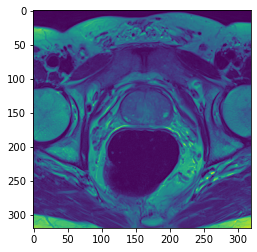

In [9]:
plt.imshow(sitk.GetArrayFromImage(image)[8, :, :])

In [10]:
image = np.expand_dims(np.transpose(np.array(sitk.GetArrayFromImage(image)).astype('float32')), (0,1))

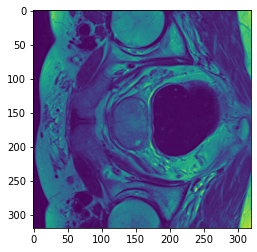

In [11]:
plt.imshow(image[0,0,:,:,8])

In [12]:
image.shape

(1, 1, 320, 320, 15)

In [13]:
np.max(image)

1486.0

In [14]:
data_transforms = Compose([
    AddChannel(),
    NormalizeIntensity(),
    ToTensor()
])

dataset = monai.data.Dataset(
    data=image,
    transform=data_transforms
)

In [15]:
dataset[0].size()

torch.Size([1, 1, 320, 320, 15])

In [16]:
test_mask = sliding_window_inference(
    dataset[0],
    roi_size=[128, 128, 16],
    sw_batch_size=1,
    predictor=model
)

In [17]:
test_mask = test_mask.argmax(1).detach().cpu().numpy()

In [18]:
test_mask.shape

(1, 320, 320, 15)

In [35]:
test_mask = np.transpose(np.squeeze(test_mask, 0))

In [36]:
test_mask.astype('uint8')

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

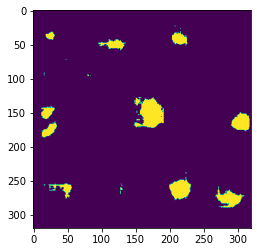

In [38]:
plt.imshow(test_mask[0,:,:])

In [ ]:
image.shape

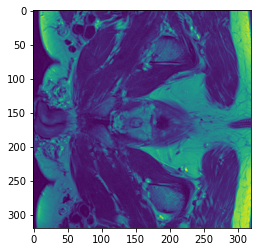

In [25]:
plt.imshow(image[0,0,:,:,2])

In [28]:
output_masks = np.load('inference-test-tool/output/output_masks_1.npy')

ValueError: Cannot load file containing pickled data when allow_pickle=False